In [1]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import copy
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import os
import random
import re
import sys
from astropy.io import fits
from comet_ml import Experiment
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchmetrics import Dice
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import segmentation_models_pytorch as smp

In [3]:
hiperparametros = {'nombre_notebook': 'Training_VIS_1000imgs_v2_efb0.ipynb',
                    'nombre_experimento' : 'Training_VIS_1000imgs_v2_efb0',
                    'nombre_mejor_modelo_a_guardar' : 'VIS_1000imgs_v2_efb0',
                    'device' : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
                    'ruta_galaxias' : 'galaxies_train_VIS/galaxy_and_stream_convolved*',
                    'ruta_mascaras' : '../masks_VIS/mask_',
                    'ruta_galaxias_test' : 'galaxies_test_VIS/galaxy_and_stream_convolved*.fits',
                    'ruta_mascaras_test' : '../masks_VIS/mask_',
                    'ancho_imagen_original' : 600,
                    'alto_imagen_original' : 600,
                    'ancho_imagen_deseado' : 608,
                    'alto_imagen_deseado' : 608,
                    'epocas' : 500,
                    'lr' : 1e-3,
                    'regularizacion_ridge' : 1e-5,
                    'torch seed model weights' : 10,
                    'batch_size' : 4,
                    'loss' : torch.nn.CrossEntropyLoss()}

In [4]:
experiment = Experiment(
    api_key="dhgO2PK521nSSpRLBYPemvvs7",
    project_name="general",
    workspace="dario-torre",
    
)
experiment.set_name(hiperparametros['nombre_experimento'])
experiment.log_parameters(hiperparametros)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/dario-torre/general/ae3bcb5122e24817b862f7a27ff20859



In [5]:
device = hiperparametros['device']

In [6]:
def get_galaxy_number(galaxy_name:str):
    return os.path.basename(galaxy_name).split('_')[4]

def get_galaxy_magnitude(galaxy_name:str):
    return os.path.basename(galaxy_name).split('_')[5]

def normalize_01(inp: np.ndarray):
    """Squash image input to the value range [0, 1] (no clipping)"""
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out

def imagen_logaritmica(img: np.ndarray)->np.ndarray:
    """
    Escalamos de forma logarítmica la imagen para aumentar el contraste
    """
    img_log = np.log(img, where=(img!=0))
    valor_minimo = np.min(img_log)
    np.putmask(img_log, img!=0, img_log+abs(valor_minimo))
    return img_log


In [7]:
class MyDataset(Dataset):
    """
    Dataset básico sin ningún tipo de augmentation
    """
    def __init__(self, galaxias_con_colas_de_marea, transform=None):
        """
        Constructor del dataset
        @param galaxias_con_colas_de_marea: Lista de rutas a los ficheros que contienen los datos de las galaxias
        """
        self.galaxias_con_colas_de_marea = galaxias_con_colas_de_marea
        self.transform=transform

    def __getitem__(self, index):
        #Abrimos la imagen de la galaxia con cola de marea
        galaxy_fits = fits.open(self.galaxias_con_colas_de_marea[index])
        x = galaxy_fits[0].data.astype(np.float32)
        #Abrimos la mascara correspondiente a la imagen
        numero_galaxia = get_galaxy_number(self.galaxias_con_colas_de_marea[index])
        magnitud_galaxia = get_galaxy_magnitude(self.galaxias_con_colas_de_marea[index])
        y = np.array(cv2.imread(hiperparametros['ruta_mascaras']+str(numero_galaxia)+"_"+str(magnitud_galaxia)+".png",0)).astype(np.float32)
        x = imagen_logaritmica(x)
        x = normalize_01(x)
        # Assuming 'input_item' is your input image
        x = cv2.resize(x, (hiperparametros['ancho_imagen_deseado'], hiperparametros['alto_imagen_deseado']))
        y = cv2.resize(y, (hiperparametros['ancho_imagen_deseado'], hiperparametros['alto_imagen_deseado']))
        if(self.transform is not None):
            augmented = self.transform(image=x, mask=y)
            x_tensor= augmented["image"]
            y_tensor= augmented["mask"].long()
        else:
            x_tensor = torch.from_numpy(x).float()
            x_tensor=torch.unsqueeze(x_tensor, dim=0)
            y_tensor = torch.from_numpy(y).long()
        
        #Hacemos reshape de los tensores
        y_tensor=torch.unsqueeze(y_tensor, dim=0)
        return x_tensor, y_tensor
    
    def __len__(self):
        """
        Devuelve la longitud del dataset
        """
        return len(self.galaxias_con_colas_de_marea)
    
class MyDatasetTest(Dataset):
    """
    Dataset básico sin ningún tipo de augmentation
    """
    def __init__(self, galaxias_con_colas_de_marea, transform=None):
        """
        Constructor del dataset
        @param galaxias_con_colas_de_marea: Lista de rutas a los ficheros que contienen los datos de las galaxias
        """
        self.galaxias_con_colas_de_marea = galaxias_con_colas_de_marea
        self.transform=transform

    def __getitem__(self, index):
        #Abrimos la imagen de la galaxia con cola de marea
        galaxy_fits = fits.open(self.galaxias_con_colas_de_marea[index])
        x = galaxy_fits[0].data.astype(np.float32)
        #Abrimos la mascara correspondiente a la imagen
        numero_galaxia = get_galaxy_number(self.galaxias_con_colas_de_marea[index])
        magnitud_galaxia = get_galaxy_magnitude(self.galaxias_con_colas_de_marea[index])
        y = np.array(cv2.imread(hiperparametros['ruta_mascaras_test']+str(numero_galaxia)+"_"+str(magnitud_galaxia)+".png",0)).astype(np.float32)
        x = imagen_logaritmica(x)
        x = normalize_01(x)
        # Assuming 'input_item' is your input image
        x = cv2.resize(x, (hiperparametros['ancho_imagen_deseado'], hiperparametros['alto_imagen_deseado']))
        y = cv2.resize(y, (hiperparametros['ancho_imagen_deseado'], hiperparametros['alto_imagen_deseado']))
        if(self.transform is not None):
            augmented = self.transform(image=x, mask=y)
            x_tensor= augmented["image"]
            y_tensor= augmented["mask"].long()
        else:
            x_tensor = torch.from_numpy(x).float()
            x_tensor=torch.unsqueeze(x_tensor, dim=0)
            y_tensor = torch.from_numpy(y).long()
        
        #Hacemos reshape de los tensores
        y_tensor=torch.unsqueeze(y_tensor, dim=0)
        return x_tensor, y_tensor
    
    def __len__(self):
        """
        Devuelve la longitud del dataset
        """
        return len(self.galaxias_con_colas_de_marea)

In [8]:
augmentation = A.Compose([
    A.Flip(p=0.8),
    #A.Rotate(limit=(-180, 180), border_mode='random', p=0.99), 
    A.ShiftScaleRotate(shift_limit=0.4, rotate_limit=180, p=0.8),
    A.GaussNoise(var_limit=(0.001), mean=(0.04), p=0.99),
    ToTensorV2(),
])

In [9]:
imagenes_train = glob.glob(hiperparametros['ruta_galaxias'])
imagenes_valid = glob.glob(hiperparametros['ruta_galaxias_test'])
print("Number of train images: " + str(len(imagenes_train)))
print("Number of valid images: " + str(len(imagenes_valid)))
dataset_augmentations = MyDataset(imagenes_train, augmentation)
train_dataset= ConcatDataset([dataset_augmentations])
valid_dataset= MyDatasetTest(imagenes_valid)
train_dataloader = DataLoader(train_dataset, batch_size=hiperparametros['batch_size'], shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=hiperparametros['batch_size'], shuffle=True)

Number of train images: 6963
Number of valid images: 1746


## Creación del modelo

In [10]:
unet = smp.Unet(
    encoder_name="efficientnet-b0",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2,                      # model output channels (number of classes in your dataset)
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /home/dario/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 38.3MB/s]


In [11]:
torch.manual_seed(hiperparametros['torch seed model weights'])
unet.to(device)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [12]:
#Imprimimos la arquitectura de la red
summary(unet, (1, 608, 608))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 1, 609, 609]               0
Conv2dStaticSamePadding-2         [-1, 32, 304, 304]             288
       BatchNorm2d-3         [-1, 32, 304, 304]              64
MemoryEfficientSwish-4         [-1, 32, 304, 304]               0
         ZeroPad2d-5         [-1, 32, 306, 306]               0
Conv2dStaticSamePadding-6         [-1, 32, 304, 304]             288
       BatchNorm2d-7         [-1, 32, 304, 304]              64
MemoryEfficientSwish-8         [-1, 32, 304, 304]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I

torch.Size([2, 608, 608])


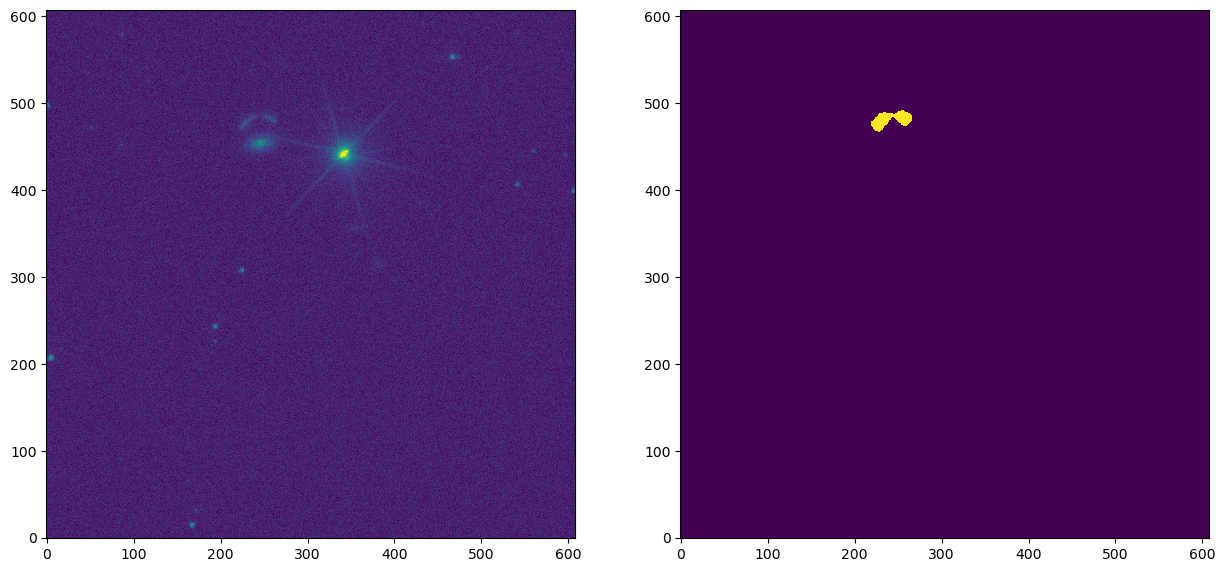

In [13]:
#Comprobamos que hemos construido la arquitectura de la red correctamente cargando una imagen del dataset
input_item, label_item = train_dataset.__getitem__(0)
input_item = input_item.reshape((1,1,hiperparametros['ancho_imagen_deseado'],hiperparametros['alto_imagen_deseado']))
label_item = label_item.reshape((1,1,hiperparametros['ancho_imagen_deseado'],hiperparametros['alto_imagen_deseado']))
output_item = unet(input_item.to(device)).cpu().detach().squeeze()
print(output_item.shape)
out_softmax = torch.softmax(output_item, dim=0)
mascara_predicha = torch.argmax(out_softmax, dim=0).numpy()
fig, (axs0, axs1) = plt.subplots(1,2, figsize = (15,15))
axs0.imshow(input_item.squeeze(), interpolation='none', origin="lower")
axs1.imshow(label_item.squeeze(), interpolation='none', origin="lower")
#plt.imshow(mascara_predicha, interpolation='none', origin="lower")
#plt.colorbar()
plt.show()

## Bucle de entrenamiento

In [14]:
criterio_loss = hiperparametros['loss']
optimizer = torch.optim.Adam(unet.parameters(), lr=hiperparametros['lr'], weight_decay = hiperparametros['regularizacion_ridge'])
mejor_modelo = None
mejor_loss = 100000000
#Inicializamos la métrica de Dice
dice = Dice(num_classes=2, average='macro', ignore_index=0)
dice.cuda()
train_loss_list = []
valid_loss_list = []
train_dice_list = []
valid_dice_list = []
for epoch in range(hiperparametros['epocas']):
    experiment.set_epoch(epoch)
    #Parte de train
    loss_medio_train = 0
    dice_medio_train=0
    pasos_train = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = unet(inputs)
        targets = torch.squeeze(labels, dim=1).type(torch.LongTensor).to(device)
        loss = criterio_loss(outputs, targets)
        valor_dice = dice(outputs, targets)
        loss_medio_train += loss.item()
        dice_medio_train += valor_dice.item()
        pasos_train += 1
        loss.backward()
        optimizer.step()
    
    experiment.log_metric('Loss train', loss_medio_train/pasos_train)
    experiment.log_metric('Dice train', dice_medio_train/pasos_train)
    unet.eval()
    
    #Parte de validacion
    loss_medio_valid = 0
    dice_medio_valid = 0
    pasos_valid = 0
    
    for i, data in enumerate(valid_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = unet(inputs)
        targets = torch.squeeze(labels, dim=1).type(torch.LongTensor).to(device)        
        loss = criterio_loss(outputs, targets)
        valor_dice = dice(outputs, targets)
        loss_medio_valid += loss.item()
        dice_medio_valid += valor_dice.item()
        pasos_valid += 1
    experiment.log_metric('Loss valid', loss_medio_valid/pasos_valid)
    experiment.log_metric('Dice valid', dice_medio_valid/pasos_valid)
    #Resultados del epoch
    print("Época: "+ str(epoch) +": Loss_train:"+ str(loss_medio_train/pasos_train)+" Loss_valid:"+str(loss_medio_valid/pasos_valid)+ "\n Dice_train: "+ str(dice_medio_train/pasos_train)+ " Dice_valid: "+str(dice_medio_valid/pasos_valid))
    train_loss_list.append(loss_medio_train/pasos_train)
    valid_loss_list.append(loss_medio_valid/pasos_valid)
    if (loss_medio_valid/pasos_valid) < mejor_loss:
        mejor_modelo = copy.deepcopy(unet)
        mejor_loss = loss_medio_valid/pasos_valid
    unet.train()
print('\n\nFinished Training')
print('Mejor loss sobre validación alcanzado:', mejor_loss)

KeyboardInterrupt: 

In [ ]:
torch.save(mejor_modelo.state_dict(), hiperparametros['nombre_mejor_modelo_a_guardar'])

## Comprobar resultados con el conjunto de train

In [ ]:
"""
ancho = hiperparametros['ancho_imagen_deseado']
alto =hiperparametros['alto_imagen_deseado']
np.set_printoptions(threshold=sys.maxsize)
mejor_modelo.eval()
for i in range(int(len(train_dataset)*0.01)):
    item_dataset = train_dataset.__getitem__(i)
    item_x = item_dataset[0].reshape((1,1,ancho,alto)).cpu().detach().squeeze().numpy()
    item_label = item_dataset[1].reshape((1,1,ancho,alto)).cpu().detach().squeeze().numpy()
    #Obtenemos predicción de la red
    prediccion_item_tensor = mejor_modelo(item_dataset[0].reshape((1,1,ancho,alto)).to(device)).cpu().detach().squeeze()
    out_softmax = torch.softmax(prediccion_item_tensor, dim=0) #Aplicamos una softmax al final (teoricamente no afecta)
    mascara_predicha = torch.argmax(out_softmax, dim=0).numpy()
    #Mostramos imagen, mascara y mascara predicha
    fig, (axs0, axs1, axs2) = plt.subplots(1,3, figsize = (15,15))    
    axs0.imshow(item_x, interpolation='none', origin="lower")
    axs1.imshow(item_label, interpolation='none', origin="lower")
    axs2.imshow(mascara_predicha, interpolation='none', origin="lower")
    plt.show()
"""

## Comprobar resultados con el conjunto de validacion

In [ ]:
"""
ancho = hiperparametros['ancho_imagen_deseado']
alto =hiperparametros['alto_imagen_deseado']
np.set_printoptions(threshold=sys.maxsize)
mejor_modelo.eval()
for i in range(int(len(valid_dataset)*0.2)):
    item_dataset = valid_dataset.__getitem__(i)
    item_x = item_dataset[0].reshape((1,1,ancho,alto)).cpu().detach().squeeze().numpy()
    item_label = item_dataset[1].reshape((1,1,ancho,alto)).cpu().detach().squeeze().numpy()
    #Obtenemos predicción de la red
    prediccion_item_tensor = mejor_modelo(item_dataset[0].reshape((1,1,ancho,alto)).to(device)).cpu().detach().squeeze()
    mascara_predicha = torch.argmax(prediccion_item_tensor, dim=0).numpy()
    #Mostramos imagen, mascara y mascara predicha
    fig, (axs0, axs1, axs2) = plt.subplots(1,3, figsize = (15,15))
    axs0.imshow(item_x, interpolation='none', origin="lower")
    axs1.imshow(item_label, interpolation='none', origin="lower")
    axs2.imshow(mascara_predicha, interpolation='none', origin="lower")
    plt.show()
"""

In [ ]:
experiment.end()